In [ ]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
B = 8
H = 10 # Grid height
W = 10 # Grid width
N = H*W # Nodes in grpah
M = 15 # previous time steps
T = 5 # future time steps
TIME_STEP = 60

In [ ]:
def normalize(vec):
    return (vec-min(vec))/(max(vec)-min(vec))

df = pd.read_csv('gdrive/MyDrive/trace/trace_avg.csv')
MAX_COST = 200
df = df[df['Cost'] < MAX_COST]
df['Cost'] = df['Cost'] / MAX_COST
df['Long'] = normalize(df['Long'])
df['Lat'] = normalize(df['Lat'])

df['TimeStep'] = round(df['TimeSec'] / TIME_STEP)
df['LongStep'] = round(df['Long'] * (H-1))
df['LatStep'] = round(df['Lat'] * (W-1))
df['GraphNode'] = (df['LongStep']-1) * W + df['LatStep']
df = df.groupby(['GraphNode', 'TimeStep'])['Cost'].mean().reset_index()

############################################################

times = np.unique(df['TimeStep'])
dataset = []

for t in times:
    grid = np.ones((H*W, 1)) * -1
    df_t = df[df['TimeStep'] == t]
    for index, row in df_t.iterrows():
        lat_step = row['GraphNode'] % W
        long_step = (row['GraphNode'] - lat_step) / W + 1
        index = int(W*(long_step-1)+lat_step)
        grid[index] = row['Cost']
    dataset.append(grid)
dataset = np.array(dataset)
del df

############################################################

indf = []
outdf = []

for i in range(len(dataset)-M-T-1):
    indf.append(dataset[i:i+M])
    outdf.append(dataset[i+M:i+M+T])

del dataset

L = len(indf)
cutoff = L-L%B
indf = np.swapaxes(np.array(indf), 1, 2)[:cutoff]
outdf = np.swapaxes(np.array(outdf), 1, 2)[:cutoff]

indf = np.reshape(indf, (-1, B, indf.shape[1], indf.shape[2]))
outdf = np.reshape(outdf, (-1, B, outdf.shape[1], outdf.shape[2]))

l = int(0.9*len(indf))
indf_train = indf[:l]
outdf_train = outdf[:l]
indf_test = indf[l:]
outdf_test = outdf[l:]

In [ ]:
 def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    d_A = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(d_A)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights


def create_mask(seq):
    x = tf.cast(tf.math.equal(seq, -1.0), tf.float32)
    x_ = tf.transpose(x, perm=[0, 2, 1])
    t_mask = tf.matmul(x[:, :, :, np.newaxis], x[:, :, np.newaxis, :])
    s_mask = tf.matmul(x_[:, :, :, np.newaxis], x_[:, :, np.newaxis, :])
    return s_mask, t_mask


def loss_function(real, pred, loss_func):
    mask = tf.math.logical_not(tf.math.equal(real, -1.0))
    if loss_func == 'MSE':
        loss = tf.square(tf.cast(real, dtype=tf.float32) - tf.cast(pred, dtype=tf.float32))
    elif loss_func == 'MAE':
        loss = tf.abs(tf.cast(real, dtype=tf.float32) - tf.cast(pred, dtype=tf.float32))
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)


def point_wise_feed_forward_network(d_G):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(d_G, activation='relu'),
        # tf.keras.layers.Dense(d_G, activation='relu'),
        # tf.keras.layers.Dense(d_G, activation='relu')
    ])

In [ ]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, d_A, d_G):
        super(Attention, self).__init__()
        self.d_G = d_G
        self.d_A = d_A
        self.wq = tf.keras.layers.Dense(d_A)
        self.wk = tf.keras.layers.Dense(d_A)
        self.wv = tf.keras.layers.Dense(d_G)
        self.dense = tf.keras.layers.Dense(d_G)

    def call(self, q, k, v, mask):
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        output = self.dense(scaled_attention)
        return output, attention_weights



class FeatureAggregation(tf.keras.layers.Layer):
    def __init__(self, d_G):
        super(FeatureAggregation, self).__init__()
        self.conv = tf.keras.layers.Conv2D(d_G, (1,1))

    def call(self, x):
        x = x[:, :, :, tf.newaxis]
        x = self.conv(x)
        return x



class DynamicSpatialLayer(tf.keras.layers.Layer):
    def __init__(self, d_A, d_G):
        super(DynamicSpatialLayer, self).__init__()
        self.att = Attention(d_A, d_G)

    def call(self, x, mask):
        x_ = tf.transpose(x, perm=[0, 2, 1, 3])
        ds_out, ds_att = self.att(x_, x_, x_, mask)
        ds_out = tf.transpose(ds_out, perm=[0, 2, 1, 3])
        return ds_out + x, ds_att



class SpatialLayer(tf.keras.layers.Layer):
    def __init__(self, d_A, d_G):
        super(SpatialLayer, self).__init__()
        self.d_A = d_A
        self.d_G = d_G
        self.ds_layer = DynamicSpatialLayer(d_A, d_G)
        self.feed_forward_network = point_wise_feed_forward_network(d_G)

    def call(self, x, mask):
        ds_out, ds_att = self.ds_layer(x, mask)
        out = self.feed_forward_network(ds_out)
        return out + x, None, ds_att



class TemporalLayer(tf.keras.layers.Layer):
    def __init__(self, d_A, d_G):
        super(TemporalLayer, self).__init__()
        self.att = Attention(d_A, d_G)
        self.feed_forward_network = point_wise_feed_forward_network(d_G)

    def call(self, x, mask):
        t_out, t_att = self.att(x, x, x, mask)
        out = self.feed_forward_network(t_out)
        return out + x, t_att



class PredictionLayer(tf.keras.layers.Layer):
    def __init__(self, T):
        super(PredictionLayer, self).__init__()
        self.dense = tf.keras.layers.Dense(T, activation='sigmoid')
        self.conv1 = tf.keras.layers.Conv2D(10, (1,1))
        self.conv2 = tf.keras.layers.Conv2D(20, (1,1))
        
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = tf.reshape(x, (x.shape[0], x.shape[1], -1))
        x = self.dense(x)
        return x


class SpatioTemporalTransformer(tf.keras.Model):
    def __init__(self, d_A, d_G, T):
        super(SpatioTemporalTransformer, self).__init__()
        self.feature_aggregation = FeatureAggregation(d_G)
        self.spatial_transformer = SpatialLayer(d_A, d_G)
        self.temporal_transformer = TemporalLayer(d_A, d_G)
        self.prediction_layer = PredictionLayer(T)

    def call(self, inp, s_mask, t_mask):
        x = self.feature_aggregation(inp)
        s_out, ss_att, ds_att = self.spatial_transformer(x, s_mask)
        t_out, t_att = self.temporal_transformer(s_out, t_mask)
        out = self.prediction_layer(t_out)
        return out, ss_att, ds_att, t_att


In [ ]:
d_A = 64
d_G = 64

sttn = SpatioTemporalTransformer(d_A, d_G, T)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
train_loss = tf.keras.metrics.Mean(name='train_loss')

@tf.function
def train_step(inp, tar):
    
    s_mask, t_mask = create_mask(inp)

    with tf.GradientTape() as tape:
        pred = sttn(inp, s_mask, t_mask)[0]
        loss = loss_function(tar, pred, 'MSE')

    gradients = tape.gradient(loss, sttn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, sttn.trainable_variables))
    train_loss(loss)

In [ ]:
EPOCHS = 20
beginning = time.time()
for epoch in range(EPOCHS):
    for b in range(indf_train.shape[0]):
        inp = indf_train[b]
        tar = outdf_train[b]
        train_step(inp, tar)
        if b % 10 == 0:
            print(f'Epoch {epoch + 1} Batch {b} Loss {train_loss.result():.4f}')   
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f}')
print(f'Total time: {time.time() - beginning:.2f} secs\n')

Epoch 1 Batch 0 Loss 0.1234
Epoch 1 Batch 10 Loss 0.1047
Epoch 1 Batch 20 Loss 0.0954
Epoch 1 Batch 30 Loss 0.0775
Epoch 1 Batch 40 Loss 0.0639
Epoch 1 Batch 50 Loss 0.0566
Epoch 1 Batch 60 Loss 0.0486
Epoch 1 Batch 70 Loss 0.0449
Epoch 1 Batch 80 Loss 0.0418
Epoch 1 Batch 90 Loss 0.0379
Epoch 1 Batch 100 Loss 0.0360
Epoch 1 Batch 110 Loss 0.0334
Epoch 1 Batch 120 Loss 0.0310
Epoch 1 Batch 130 Loss 0.0290
Epoch 1 Loss 0.0288
Epoch 2 Batch 0 Loss 0.0286
Epoch 2 Batch 10 Loss 0.0270
Epoch 2 Batch 20 Loss 0.0254
Epoch 2 Batch 30 Loss 0.0246
Epoch 2 Batch 40 Loss 0.0234
Epoch 2 Batch 50 Loss 0.0233
Epoch 2 Batch 60 Loss 0.0224
Epoch 2 Batch 70 Loss 0.0221
Epoch 2 Batch 80 Loss 0.0220
Epoch 2 Batch 90 Loss 0.0213
Epoch 2 Batch 100 Loss 0.0212
Epoch 2 Batch 110 Loss 0.0205
Epoch 2 Batch 120 Loss 0.0199
Epoch 2 Batch 130 Loss 0.0193
Epoch 2 Loss 0.0192
Epoch 3 Batch 0 Loss 0.0192
Epoch 3 Batch 10 Loss 0.0187
Epoch 3 Batch 20 Loss 0.0181
Epoch 3 Batch 30 Loss 0.0179
Epoch 3 Batch 40 Loss 0.017

In [ ]:
# print(np.sum([np.prod(v.get_shape().as_list()) for v in sttn.trainable_variables]))
sttn.load_weights('gdrive/MyDrive/trace/sttn-1')
# err = 0.0
# cnt = 0
# for b in range(indf_test.shape[0]):
#     inp = indf_test[b]
#     tar = outdf_test[b]
#     s_mask, t_mask = create_mask(inp)
#     pred = sttn(inp, s_mask, t_mask)[0]
#     cnt += 1
#     err += loss_function(tar, pred, 'MAE')
# print(err/cnt)

In [ ]:
real = np.array([0.0])
predicted = np.array([0.0])
for b in range(indf_test.shape[0]):
    inp = indf_test[b]
    tar = outdf_test[b]
    s_mask, t_mask = create_mask(inp)
    pred = sttn(inp, s_mask, t_mask)[0]
    for i in range(B):
        indices = np.array(tf.where(tar[i, :, T-1] != -1)[:, 0])
        real = np.concatenate([real, tar[i, indices, T-1]])
        predicted = np.concatenate([predicted, np.array(pred)[i, indices, 0]])
real = real[1:]
predicted = predicted[1:]

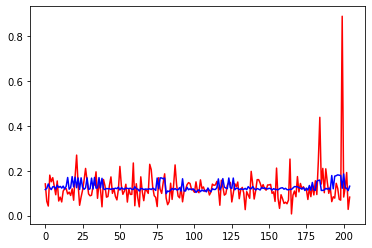

In [ ]:
plt.plot(np.arange(len(real)), real, 'red')
plt.plot(np.arange(len(predicted)), predicted, 'blue')
plt.show()